# 3.7 Modelo de Clasificación Naive Bayes

### Miguel Ángel Jiménez Cuadrillero
### 2020

*OBJETIVO*: Predecir si un empleado abandonará la empresa o no en base a sus datos de contexto.


El clasificador Naïve Bayes es un clasificador probabilístico simple que se basa en el teorema de Bayes pero con fuertes suposiciones con respecto a la independencia. Históricamente, esta técnica se hizo popular entre las aplicaciones de filtrado de correo electrónico, detección de spam y categorización de documentos. Aunque a menudo es superado por otras técnicas, y a pesar del diseño ingenuo y los supuestos demasiado simplificados, este clasificador puede funcionar bien en muchos problemas complejos del mundo real. Y dado que es un algoritmo eficiente en recursos que es rápido y escala bien, definitivamente es un algoritmo de aprendizaje automático para tener en nuestro kit de herramientas.

<img src="images/naive_bayes_icon.png">


## Video sobre el Teorema de Bayes
https://youtu.be/Fi6G48j0IZ4



Predice la probabilidad de pertenencia a una clase usando el teorema de Bayes que está basado en la probabilidad condicionada, que es la probabilidad de algo suceda si algo ya ha ocurrido.

Las observaciones se clasifican en la clase que tenga una probabilidad mayor.


Aunque la ecuación tiene una belleza simplista en su superficie, se vuelve compleja e intratable a medida que crece el número de variables predictoras. De hecho, para calcular la probabilidad posterior de una variable de respuesta con m clases y un conjunto de datos con predictores p, la ecuación requeriría m^p probabilidades calculadas 

En el ejemplo actual para este dataset tenemos 2 clases (deserción versus no deserción) y 31 variables, que requieren 2,147,483,648 probabilidades calculadas.

## El clasificador simplificado

En consecuencia, el clasificador ingenuo de Bayes hace una suposición simplificadora para permitir que el cálculo sea escalable. Con Bayes ingenuo, suponemos que las variables predictoras son condicionalmente independientes entre sí dado el valor de respuesta. Esta es una suposición extremadamente fuerte. Podemos ver rápidamente que nuestros datos que no cumplen esto, ya que tenemos varias variables de moderadamente a fuertemente correlacionadas.



In [1]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
from sklearn.model_selection import train_test_split
plt.figure(figsize=(20,5))

random_state = 123

from sklearn import datasets

<Figure size 1440x360 with 0 Axes>

In [19]:
df = pd.read_csv("./datasets/attrition.csv", sep=',')

categorical_features = ['YearsWithCurrManager', 'WorkLifeBalance', 'PerformanceRating', 'RelationshipSatisfaction', 'OverTime', 
                   'JobRole', 'JobSatisfaction', 'MaritalStatus', 'JobInvolvement', 'Education', 'EducationField', 
                   'EnvironmentSatisfaction', 'Gender', 'Department', 'BusinessTravel', ]
numeric_features = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'JobLevel', 'MonthlyIncome', 'MonthlyRate', 
               'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
               'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', ]

label = ['Attrition']

corr_df = df[numeric_features] 
cor = corr_df.corr(method='pearson')
print(cor)

                              Age  DailyRate  DistanceFromHome  HourlyRate  \
Age                      1.000000   0.010661         -0.001686    0.024287   
DailyRate                0.010661   1.000000         -0.004985    0.023381   
DistanceFromHome        -0.001686  -0.004985          1.000000    0.031131   
HourlyRate               0.024287   0.023381          0.031131    1.000000   
JobLevel                 0.509604   0.002966          0.005303   -0.027853   
MonthlyIncome            0.497855   0.007707         -0.017014   -0.015794   
MonthlyRate              0.028051  -0.032182          0.027473   -0.015297   
NumCompaniesWorked       0.299635   0.038153         -0.029251    0.022157   
PercentSalaryHike        0.003634   0.022704          0.040235   -0.009062   
StockOptionLevel         0.037510   0.042143          0.044872    0.050263   
TotalWorkingYears        0.680381   0.014515          0.004628   -0.002334   
TrainingTimesLastYear   -0.019621   0.002453         -0.036942  

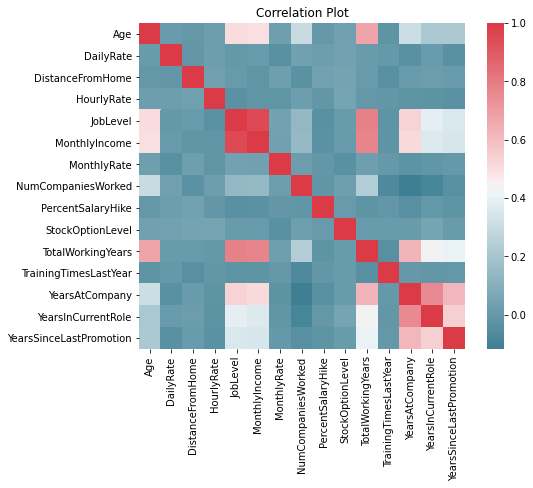

In [20]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Al hacer esta suposición, podemos simplificar nuestro cálculo de modo que la probabilidad posterior sea simplemente el producto de la distribución de probabilidad para cada variable individual condicionada a la categoría de respuesta. Ahora solo estamos obligados a calcular m * p probabilidades (esto equivale a 62 probabilidades para nuestro conjunto de datos), una tarea mucho más manejable.

Cuando se incluyen variables predictoras continuas, a menudo se hace una suposición de normalidad para que podamos usar la probabilidad de la función de densidad de probabilidad de la variable. Si seleccionamos características numéricas, rápidamente vemos que la suposición de normalidad no siempre se ajusta.

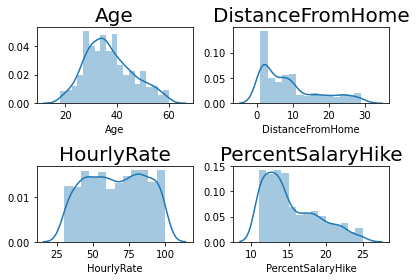

In [21]:
for i, numeric_variable in enumerate(['Age', 'DistanceFromHome', 'HourlyRate', 'PercentSalaryHike']):
    
    ax = plt.subplot(2, 2, i + 1)
    
    # Title and labels
    ax.set_title(numeric_variable, size = 20)
    sns.distplot(df[numeric_variable])


plt.tight_layout()
plt.show()

Por supuesto, algunas características numéricas pueden normalizarse con una transformación de Box-Cox o aplicando logaritmos. En última instancia, transformar las distribuciones y seleccionar un estimador es parte del proceso de desarrollo y ajuste del modelado.


## Entrenamiento del Modelo


## División Train/Test


In [31]:
df = pd.read_csv("./datasets/attrition.csv", sep=',')

y = df.pop('Attrition')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=random_state)

## Data Cleaning y Feature Engineering
### Normalización de datos

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV


from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),

    ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GaussianNB())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {
    'classifier__var_smoothing': [0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(clf,param_grid, cv=10)

grid_search.fit(X_train, y_train)

print(("Mejor accuracy para el modelo es: %.3f" % grid_search.score(X_test, y_test)))

Mejor accuracy para el modelo es: 0.823
